For improved readability of the Notebook, use [Markdown Cheat Sheet](https://gtribello.github.io/mathNET/assets/notebook-writing.html) and [Unofficial Jupyter Extensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html).

# Imports and Installations

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import functools as func
from data_preprocess import data_load, data_clean
import custom_functions as cfunc
import plot_functions as pfunc

In [2]:
# default, green, blue and red color cycles
default, color1, color2, color3 = pfunc.color_cycles()

# customize plot settings and parameters
pfunc.init_plot_settings(color=default)

# extra colors
blue_light = '#9BBEDA'
blue_medium = '#748FA4'
blue_dark = '#4E5F6D'

# Load & Prepare Data

#### RKI Coronavirus data

for the sake of having a cleaner Notebook, the loading and data wrangling code was moved to a module, `data_preprocess.py`. If you don't feel like checking out the details, this is what it does:
* load and the data from multiple csv files
* preprocess/clean data:
    * since some of the data was extracted from files with messy or incompatible formatting, cleaning included **string extractions and replacements** in different columns before numeric conversion could be done
    * furthermore, I **renamed columns** where necessary to be suitable for pandas (and for non-German speakers) and **merged suitable tables together**
    * since daily and weekly case numbers are mixed in this dataset, I made sure every table included the **calendar week as a common time-based reference for comparison** between tables (where week 53 is mapped to the year 2020)
* after these steps, the output is as follows:
    * `overview`: daily new cases and deaths over time in all federal states (per general age group and sex)
    * `cases_age`: weekly number of new cases and incidences per age group in 5-year intervalls
    * `clinical`: reported clinical indications (hospitalization, symptom prevalence) and deaths per sex
    * `deaths`: weekly number of deaths per age group and sex
    * `breakouts`: breakouts (= 2 or more cases) that were traced and attributed to an infection setting
    * `tests`: testing capacities and tailbacks

**Information on Coronavirus case documentation:**
All data was taken from the German federal government agency responsible for disease control and prevention, Robert Koch Institute [RKI](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/nCoV_node.html). Cases are defined as infections (regardless of the presence of symptoms) which were confirmed by a laboratory PCR test. The date a Coronavirus case occurs in the data is the date the local health authorities register the case.

All data was downloaded on January 18th.

In [3]:
# load
overview, casting, breakouts, cases_age1, cases_age2, deaths1, deaths2, deaths3, tests1, tests2, clinical =\
    data_load()

In [4]:
# preprocess
overview, casting, breakouts, cases_age, deaths, tests, clinical =\
    data_clean(overview, casting, breakouts, cases_age1, cases_age2, deaths1, deaths2, deaths3, tests1, tests2, clinical)

C:\Users\Andrea\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
for dataframe in [overview, casting, breakouts, cases_age, deaths, tests, clinical]: 
    print(f'dimensions: {dataframe.shape}')

dimensions: (1030560, 22)
dimensions: (319, 14)
dimensions: (840, 3)
dimensions: (20, 91)
dimensions: (42, 22)
dimensions: (45, 7)
dimensions: (45, 13)


#### supporting data
data derived from German Federal Statistics Office (used by RKI):
* German population per federal state ([link](https://de.statista.com/statistik/daten/studie/71085/umfrage/verteilung-der-einwohnerzahl-nach-bundeslaendern/))
* German population per age group ([link](https://www-genesis.destatis.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=1&levelid=1611959825818&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=12411-0005&auswahltext=&werteabruf=Werteabruf#abreadcrumb)) or ([link](https://service.destatis.de/bevoelkerungspyramide/index.html#!))

data derived for dark figures calculation:
* Social Contacts and Mixing Patterns Relevant to the Spread of Infectious Diseases ([link](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0050074))

In [6]:
# use current population data (in 1000 units) to calculate incidences per federal state:
population_states = pd.Series(data={'Baden-Württemberg':11100.394, 
                                    'Bayern':13124.737, 
                                    'Berlin':3669.491,
                                    'Brandenburg':2521.893, 
                                    'Bremen':681.202, 
                                    'Hamburg':1847.253, 
                                    'Hessen':6288.080,
                                    'Mecklenburg-Vorpommern':1608.138, 
                                    'Niedersachsen':7993.608, 
                                    'Nordrhein-Westfalen':17947.221,
                                    'Rheinland-Pfalz':4093.903, 
                                    'Saarland':986.887, 
                                    'Sachsen':4071.971, 
                                    'Sachsen-Anhalt':2194.782,
                                    'Schleswig-Holstein':2903.773, 
                                    'Thüringen':2133.378})

print(f'German population according to state census: {population_states.sum()}')

German population according to state census: 83166.711


In [7]:
social_factors = pd.DataFrame(data={'Altersgruppe':['90+', '85 - 89', '80 - 84', '75 - 79', '70 - 74', '65 - 69', '60 - 64', '55 - 59', '50 - 54', '45 - 49', '40 - 44', '35 - 39', '30 - 34', '25 - 29', '20 - 24', '15 - 19', '10-14', '5-9', '0 - 4'], 
                                    'social_contacts':[0.81, 0.81, 0.81, 0.81, 0.81, 1.06, 1.06, 1.31, 1.31, 1.38, 1.38, 1.45, 1.45, 1.45, 1.45, 1.68, 1.73, 1.42, 1], 
                                    'social_contacts_95_low':[0.73, 0.73, 0.73, 0.73, 0.73, 0.96, 0.96, 1.20, 1.20, 1.27, 1.27, 1.34, 1.34, 1.33, 1.33, 1.52, 1.57, 1.28, 1], 
                                    'social_contacts_95_high':[0.88, 0.88, 0.88, 0.88, 0.88, 1.16, 1.16, 1.42, 1.42, 1.50, 1.50, 1.57, 1.57, 1.57, 1.57, 1.84, 1.90, 1.55, 1]})
social_factors = social_factors.set_index('Altersgruppe')

In [8]:
# use current population data (in 1000 units) to calculate incidences per age group (0-100 years):
# population_age = pd.read_csv("data/12411-0005.csv", sep=';', encoding = "ISO-8859-1")
population_age = pd.read_csv("data/14_bevoelkerungsvorausberechnung_daten.csv", sep=';')
population_age = population_age[(population_age['Variante'] == 10) & (population_age['Simulationsjahr'] == 2019)].sum().iloc[4:]

# reset index instead of renaming to be between 0 and 100
population_age = population_age.reset_index(drop=True)

# group in age groups of five years (0-4, 5-9, ...)
population_age = population_age.groupby(population_age.index // 5).sum()

# add 90-94 and 95-99 as age group '90+' and set index accordingly
population_age.loc[18] += population_age.loc[19]
population_age = population_age.loc[0:18]
population_age.index = ['0 - 4','5-9','10-14','15 - 19',
                        '20 - 24','25 - 29','30 - 34','35 - 39',
                        '40 - 44','45 - 49','50 - 54','55 - 59',
                        '60 - 64','65 - 69','70 - 74','75 - 79',
                        '80 - 84','85 - 89','90+']

print(f'German population according to age census: {population_age.sum()}')

German population according to age census: 83178.0


#### view data

In [9]:
overview.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,IdLandkreis,NeuerFall,NeuerTodesfall,...,IstErkrankungsbeginn,report_date,ref_date,report_delay,ref_date_dayofweek,ref_date_year,ref_date_week,report_date_dayofweek,report_date_year,report_date_week
0,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,1001,0,-9,...,0,2020-09-30,2020-09-30,0,2,2020,40,2,2020,40
1,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,1,0,1001,0,-9,...,1,2021-01-05,2021-01-03,2,6,2020,53,1,2021,1
2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,1001,0,-9,...,0,2020-10-29,2020-10-29,0,3,2020,44,3,2020,44
3,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,2,0,1001,0,-9,...,0,2021-01-05,2021-01-05,0,1,2021,1,1,2021,1
4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,1001,0,-9,...,0,2020-11-03,2020-11-03,0,1,2020,45,1,2020,45


In [10]:
breakouts.head()

,week,sett_engl,num_breakouts
0,9,Private household,2
1,9,Retirement/nursing home,1
2,9,Work place,1
3,9,Educational institution,3
4,9,Leisure,77


In [11]:
cases_age.head()

,Altersgruppe,2020_10_total,2020_11_total,2020_12_total,2020_13_total,2020_14_total,2020_15_total,2020_16_total,2020_17_total,2020_18_total,...,2020_45_incidence,2020_46_incidence,2020_47_incidence,2020_48_incidence,2020_49_incidence,2020_50_incidence,2020_51_incidence,2020_52_incidence,2020_53_incidence,2021_1_incidence
0,Gesamt,895,6435,22432,34029,36093,27185,17368,12381,7443,...,151.28,153.78,154.54,148.33,154.30,187.77,209.60,166.58,147.33,172.18
1,90+,1,12,99,423,1172,1245,848,582,284,...,208.98,281.15,372.40,427.31,502.77,656.95,722.19,635.69,600.09,641.28
2,85 - 89,6,38,218,738,1447,1421,926,684,329,...,146.50,180.78,215.24,261.99,292.68,376.90,441.49,372.55,355.80,380.48
3,80 - 84,12,83,468,1285,1963,1719,1182,823,451,...,104.18,115.32,132.35,145.13,164.68,213.86,249.77,224.72,207.09,229.19
4,75 - 79,24,112,571,1407,1786,1312,853,587,352,...,78.55,84.85,87.37,90.08,102.05,128.31,153.23,130.74,118.74,132.73


In [12]:
deaths.head()

,week,deaths_total,age_0,age_10,age_20,age_30,age_40,age_50,age_60,age_70,...,M0_19,M20_39,M40_59,M60_79,M80,F0_19,F20_39,F40_59,F60_79,F80
0,10,3,0,0,0,0,0,3,3,0,...,0,0,3,3,0,0,0,0,0,0
1,11,18,0,0,0,0,0,0,3,6,...,0,0,0,5,6,0,0,0,3,5
2,12,162,0,0,0,0,3,8,7,36,...,0,0,7,30,61,0,0,3,13,49
3,13,603,0,0,3,3,7,20,60,144,...,0,3,21,152,218,0,3,6,52,150
4,14,1370,0,0,3,5,9,54,127,320,...,0,5,49,317,460,0,3,14,130,393


In [13]:
tests.head()

,week,laboratories,daily_cap,weekly_cap_est,weekly_cap_real,laboratories_tailback,tests_tailback
0,11,28,7115,0,0,0.0,0.0
1,12,93,31010,0,0,0.0,0.0
2,13,111,64725,0,185655,0.0,0.0
3,14,113,103515,0,284580,0.0,0.0
4,15,132,116655,0,462880,25.0,3423.0


In [14]:
clinical.head()

,year,week,cases_tot,mean_age,male_perc,female_perc,symptoms_reported,no_symptoms_perc,hospital_reported,hospital_num,hospital_perc,deaths_num,deaths_perc
0,2020,10,895,43,0.53296,0.46704,835,0.07784,802,162,0.20200,12,0.01341
1,2020,11,6435,45,0.56288,0.43712,5780,0.05329,5615,521,0.09279,85,0.01321
2,2020,12,22432,45,0.54980,0.45020,20210,0.03859,19346,2204,0.11393,478,0.02131
3,2020,13,34029,48,0.49496,0.50504,30866,0.03246,29470,5110,0.17340,1459,0.04288
4,2020,14,36093,51,0.45074,0.54926,31986,0.05321,31488,6063,0.19255,2256,0.06251


In [15]:
social_factors.head()

,social_contacts,social_contacts_95_low,social_contacts_95_high
Altersgruppe,,,
90+,0.81,0.73,0.88
85 - 89,0.81,0.73,0.88
80 - 84,0.81,0.73,0.88
75 - 79,0.81,0.73,0.88
70 - 74,0.81,0.73,0.88


# Data Analysis & Visualization

#### general overview & exploratory analysis
* total cases, testing capacities and reporting

In [16]:
# total population
total_population = population_states.sum()
print(f'German population (in 1000 units): {total_population}')

German population (in 1000 units): 83166.711


In [17]:
# total cases (all newly reported infections, not active cases)reported until 
total_cases = overview['AnzahlFall'].sum()
print(f'Total cases reported in 2020: {total_cases}')

Total cases reported in 2020: 2040521


In [18]:
# total cases per week in 2020 (week 1-53)
weekly_cases = overview.loc[overview['report_date_year'] != 2021].groupby(['report_date_week']).sum()['AnzahlFall'].fillna(0)

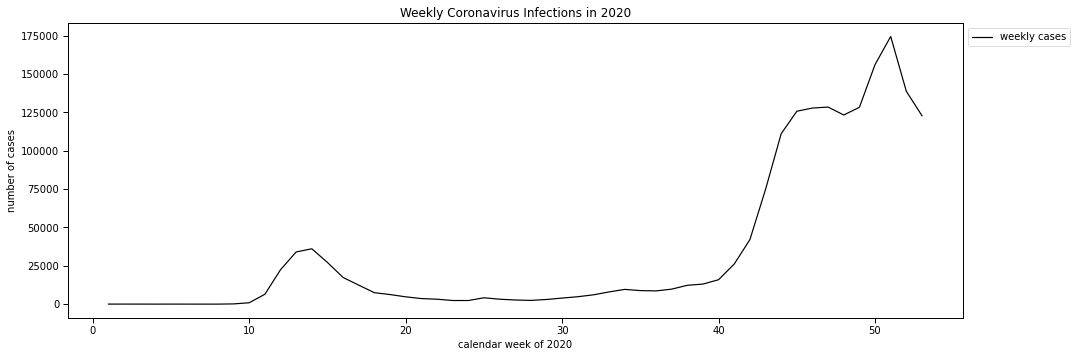

In [19]:
fig, ax = pfunc.plot_line(weekly_cases.rename('weekly cases'),
                          title=f'Weekly Coronavirus Infections in 2020',
                          xlabel='calendar week of 2020',
                          ylabel='number of cases', 
                          filename='total_weekly_cases')

During 2020, Germany went through 2 major pandemic waves: the first one in March and April (week 10-20) and the second, more severe one starting in week 40. Weekly new infections peaked during week 51, with 175000 new cases.

In [20]:
# delay in reporting (date of infection vs. date of reporting to authorities):
report_delay = overview.loc[(overview['report_delay'] >= -30) & (overview['report_delay'] <= 30)]['report_delay']

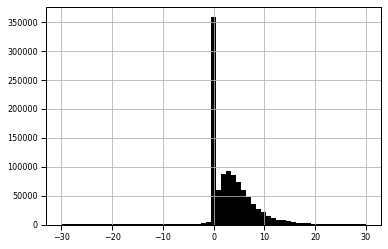

In [21]:
report_delay.hist(bins=61)

The delay between a Coronavirus infection and the notification of authorities is 0 if both occur on the same day OR if the date of infection is unknown. Since the estimated incubation period for the Coronavirus is 3-5 days on average, we can assume that the large number of null values is due to a high number of cases where the infection time (and source) is unknown. This assumption is backed by information on the RKI website, stating that "in most cases, no infection source can be determined".

There are many outliers larger that 30 days in the data, as well as negative values, which I assume to be attributed to documentation errors, overload of the responsible authorities etc.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x015B0610>,
      dtype=object)

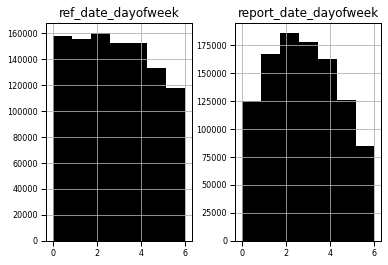

In [22]:
# distribution of report and infection over the week (Mon-Sun)
overview[['report_date_dayofweek', 'ref_date_dayofweek']].hist(bins=7)

In [23]:
tests = tests.set_index(['week'])

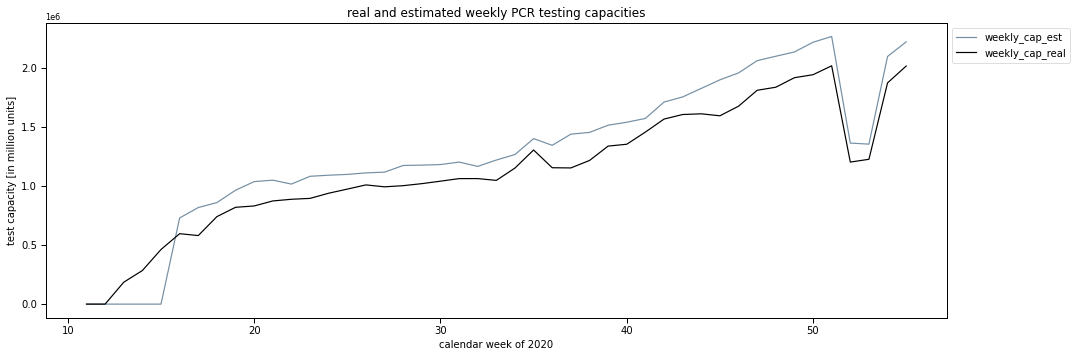

In [24]:
# real and estimated testing capacities
fig, ax = pfunc.plot_line(tests[['weekly_cap_est', 'weekly_cap_real']],
                          title=f'real and estimated weekly PCR testing capacities',
                          xlabel='calendar week of 2020',
                          ylabel='test capacity [in million units]', 
                          linecolor=[blue_medium, 'black'],
                          filename='test_capacities')

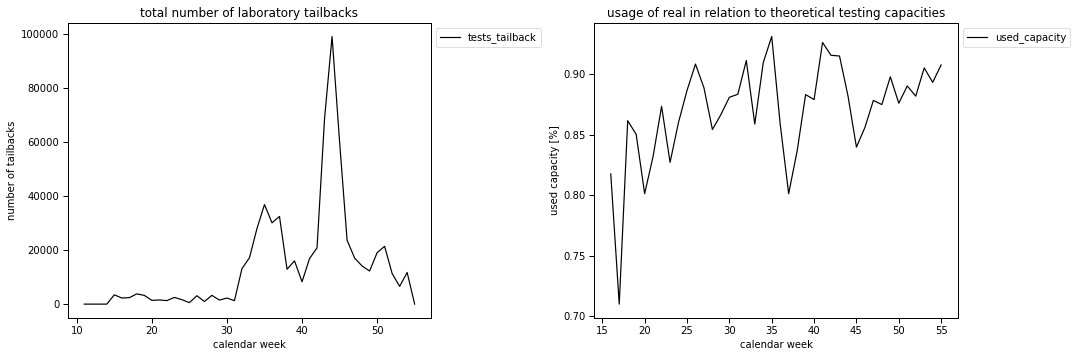

In [25]:
fig, axes = pfunc.plot_line_multi(tests['tests_tailback'], (tests['weekly_cap_real']/tests['weekly_cap_est']).rename('used_capacity'), 
                            title1='total number of laboratory tailbacks', 
                            title2='usage of real in relation to theoretical testing capacities', 
                            xlabels=['calendar week', 'calendar week'], 
                            ylabels=['number of tailbacks', 'used capacity [%]'], 
                            filename='test_capacities_tailbacks')

Real testing capacities vary between 71% and 94% of estimated testing capacities, but there is only one visible overloads which could specifically be attributed to the pandemic wave in winter: Testing tailbacks accumulate temporarily, with 100000 tests overdue in week 44, but this seems to be compensated again.

There is a distinct drop in both in real and theoretical test capacities over the christmas holidays.

Overall, test capacities only increase linearly throughout the course of the year, despite almost exponential development of infections especially during the second pandemic wave.

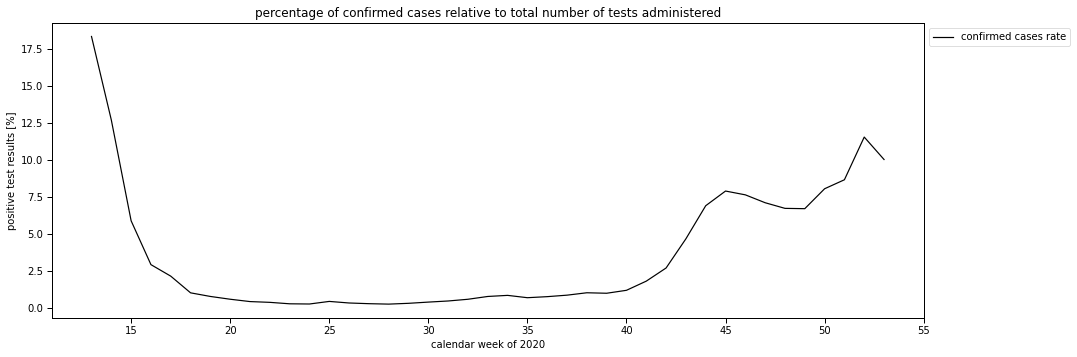

In [26]:
# test rate: percentage of detected cases relative to total number of tests administered
test_rate = (weekly_cases.loc[13:53]/tests['weekly_cap_real'].loc[13:53])*100

fig, ax = pfunc.plot_line(test_rate.rename('confirmed cases rate'),
                          title=f'percentage of confirmed cases relative to total number of tests administered',
                          xlabel='calendar week of 2020',
                          ylabel='positive test results [%]',
                          filename='test_rate')

In [27]:
print(f'minimum rate of positive test results: {test_rate.min()}%\
\nmean rate of positive test results in summer, CW 20-40: {test_rate.loc[20:40].mean()}%')

minimum rate of positive test results: 0.2418909737207574%
mean rate of positive test results in summer, CW 20-40: 0.5635633467074882%


The effects of both pandemic waves are clearly visible in the relation between positive test results and total number of tests administered: this rate drops from 18% at the beginning (little test capacities, testing only symptomatic cases) to below 0.6% during the whole summer (broad testing also for travellers, contact tracing and routine testing of potential contact persons without symptoms). During the second wave, the rates of positive test results increase again to up to 10%.

#### analyse geographical case distribution - how did the pandemic spread across the country?

**Definitions**
* case incidence = cases / 100000 people

In [28]:
# total cases per week per federal state in 2020
weekly_cases_per_state = overview.loc[overview['report_date_year'] != 2021].groupby(['Bundesland', 'report_date_week']).sum()['AnzahlFall'].unstack().fillna(0)

In [29]:
# weekly incidence per federal state
weekly_incidence_per_state = (weekly_cases_per_state.div(population_states, axis=0))*100

# total weekly incidence
weekly_incidence = (weekly_cases/total_population)*100

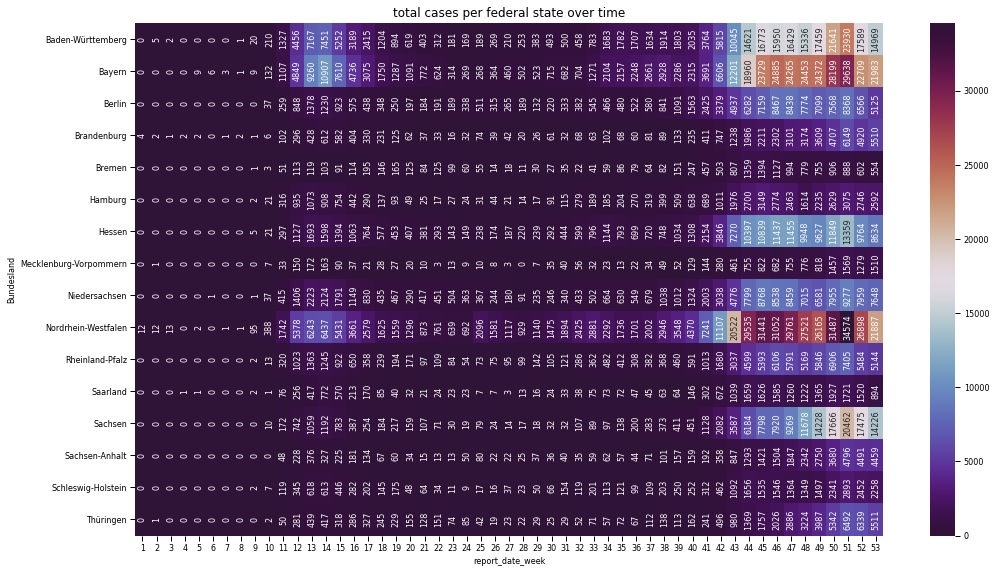

In [30]:
# heatmap: weekly cases per week per federal state in 2020
fig, ax = pfunc.plot_heatmap(weekly_cases_per_state,
                             title='total cases per federal state over time',
                             filename='cases_total_per_state',
                             figsize=(15, 8), annot=True, fmt='.0f')

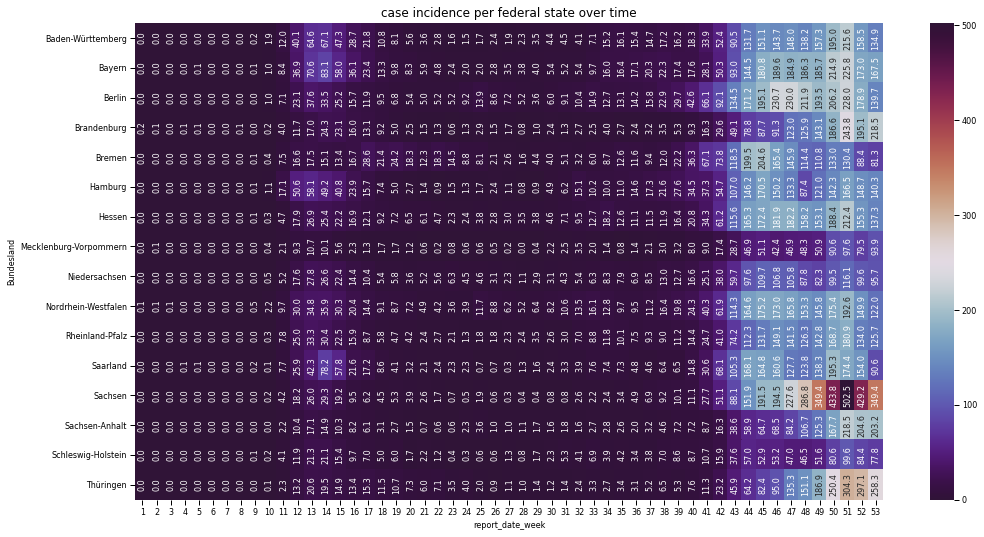

In [31]:
# heatmap: weekly incidence per week per federal state in 2020
fig, ax = pfunc.plot_heatmap(weekly_incidence_per_state,
                             title='case incidence per federal state over time',
                             filename='incidence_state',
                             figsize=(15, 7.5), annot=True, fmt='.1f')

During the first wave, infections mostly coincided with areas of high population or high population density. Both total case numbers and incidences, i.e. cases per 100,000 inhabitants, were highest in those states with the largest overall population as well as in large cities like Hamburg or Berlin (exception: Saarland close to the French border).

During the second wave, incidences were high everywhere, indicating that the **virus had by then infested the whole country instead of occuring in local clusters**. While the sparsely populated North (Mecklenburg-Western Pomerania and Schleswig-Holstein) still had the lowest incidences, two neighbouring states in eastern Germany, Thuringia and Saxony, were overproportionally hit.

#### analyze case distribution among age groups - who was affected and to what proportions?

In [32]:
# cases per age group over time (total)
age_total = cfunc.remove_column_substr(cases_age1.set_index('Altersgruppe'), '2020_').drop(['Gesamt'], axis=0)

# cases per age group over time (incidence)
age_incidence = cfunc.remove_column_substr(cases_age2.set_index('Altersgruppe'), '2020_')

# cases per age group over time (incidence) relative to overall incidence at the time
# shows the proportion to which an age group was affected in comparison to the overall population
age_norm = age_incidence/age_incidence.iloc[0,:]

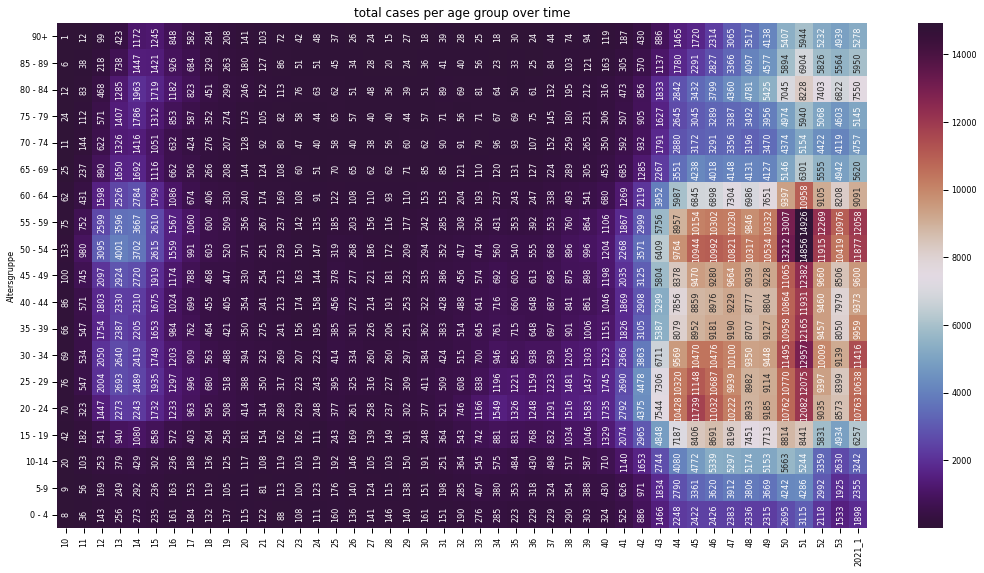

In [33]:
# heatmap: cases per age group over time (total)
fig, ax = pfunc.plot_heatmap(age_total,
                             title='total cases per age group over time',
                             filename='cases_total_per_age',
                             figsize=(15, 8), annot=True, fmt='d')

A quick glance at Germany's [age pyramid](https://service.destatis.de/bevoelkerungspyramide/index.html) shows us that age groups with a larger population have higher case numbers. Hence, case incidences (i.e. cases per 100,000 people in the respective age group) provide more comparable information about how Coronavirus infections occur across age groups.

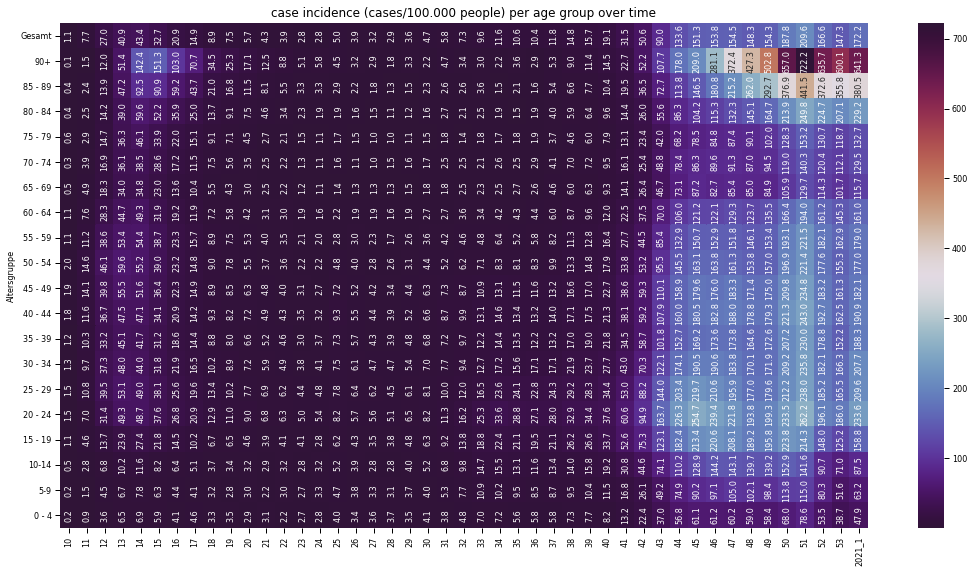

In [34]:
# heatmap: cases per age group over time (incidence)
fig, ax = pfunc.plot_heatmap(age_incidence,
                             title='case incidence (cases/100.000 people) per age group over time',
                             filename='incidence_age_overall',
                             figsize=(15, 8), annot=True, fmt='.1f')

The case incidences show that the Coronavirus did indeed spread to all age groups throughout the year, yet it did not occur evenly in all age groups. Those over 85 years of age were actually affected much heavier than all other age groups especially during the second wave, while retirees below 80 and children were affected less. Still, we do not have a clear picture of what happens over the summer.

_Solution: look at the relative case incidence_

The case incidence within a specific group in relation to the general population at the time allows us to visualize better how severely a group was affected in comparison to the general population at the time. Due to the huge range of the overall incidence over time (0...722), smaller variations are otherwise less visible. Bear in mind that the overall incidence is influenced heavily by the larger groups (i.e. the population 30-65 years of age), so these groups tend to be near a relative value of 1.

Another aspect is that when looking at correlations, total numbers and incidences give us strongly positive correlations between nearly all groups. While this holds true (case numbers nearly rise across all age groups during a pandemic), it is also interesting to see whether two groups being affected over- or underproportionally correlate with other factors.

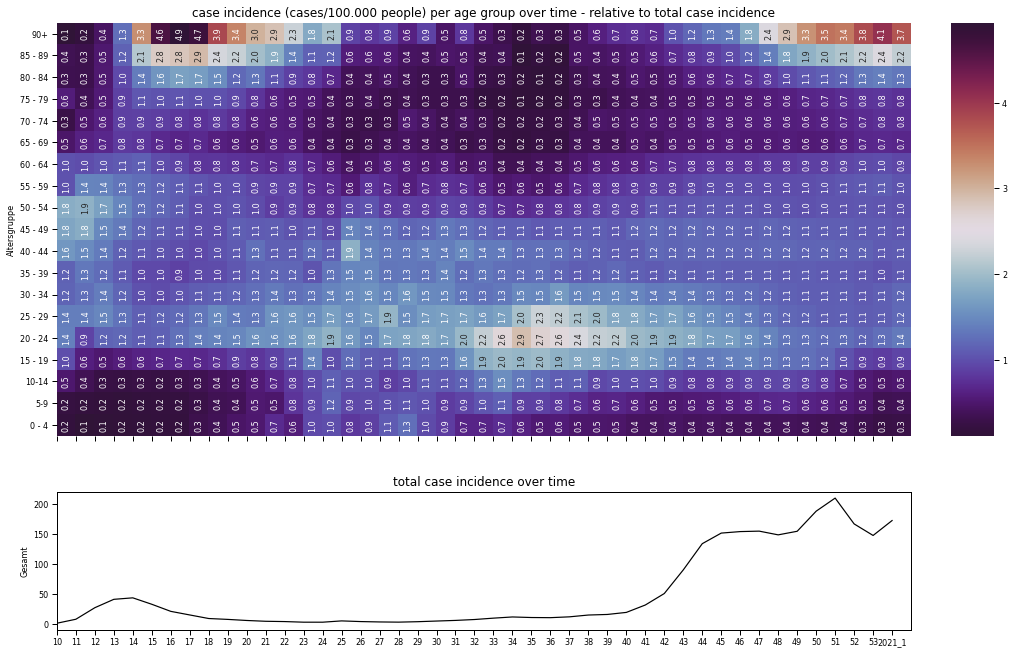

In [35]:
# heatmap: cases per age group over time (incidence) relative to overall case incidence
fig, ax = pfunc.plot_heatmap_and_line(age_norm.drop(['Gesamt'], axis=0),
                                      x_line=age_incidence.iloc[0].index, y_line=age_incidence.iloc[0], df_line=None,
                                      title1='case incidence (cases/100.000 people) per age group over time - relative to total case incidence',
                                      filename='incidence_age_relative',
                                      title2='total case incidence over time',
                                      figsize=(15, 10), annot=True, fmt='.1f')

Case incidence among those over 90 years up to 5 times higher in comparison to the overall population during times with high overall incidences, with a peak during the first wave.

During summer there is a shift: most restrictions (except for bans on large events) were lifted, people traveled and, as expected, the more mobile younger generation 20-30 had the highest incidences and case numbers.

Retirees between 65 and 70 years are constantly affected less than the general population.

In [36]:
# correlation of relative incidences between age groups
age_groups_corr = age_norm.T.corr()

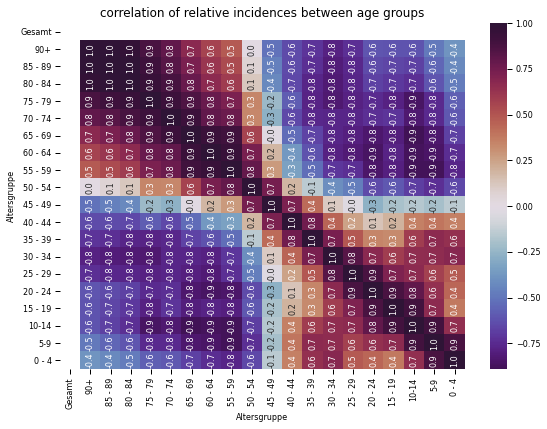

In [37]:
# correlation of _proportion_ to which two groups were affected by the Coronavirus
fig, ax = pfunc.plot_heatmap(age_groups_corr,
                             title=f'correlation of relative incidences between age groups',
                             filename='corr_age_groups',
                             annot=True, fmt='.1f', figsize=(8,6), center=0)

#### analyze breakouts - which infection sources are dominant over time and who is affected?
* breakout = 2 or more related cases that were documented as being related
* setting = environment in which the infections occurred

In [38]:
# total number of cases attributed to breakouts - grouped in different infection settings
breakouts_time_per_setting = breakouts.groupby(['week', 'sett_engl'])['num_breakouts'].sum().unstack().fillna(0)

# top 10 infection settings
breakouts_time_per_setting.sum().sort_values(ascending=False).head(n=10)

sett_engl
Private household          101099.0
Retirement/nursing home     86101.0
Unknown                     37317.0
Work place                  20715.0
Hospital                    15849.0
Other                       10260.0
Refugee accomodation         9586.0
Leisure                      7303.0
Residences                   6849.0
Educational institution      5892.0
dtype: float64

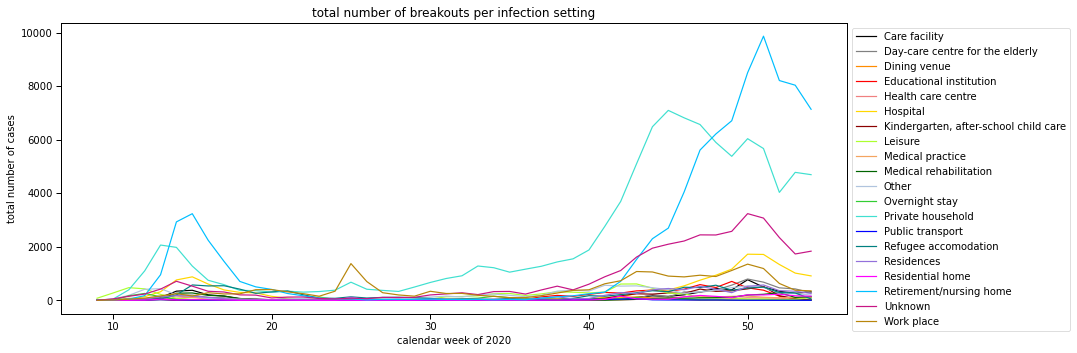

In [39]:
# total number of cases attributed to breakouts per infection setting
fig, ax = pfunc.plot_line(breakouts_time_per_setting,
                          title='total number of breakouts per infection setting', 
                          xlabel='calendar week of 2020', 
                          ylabel='total number of cases', 
                          linecolor=default,
                          filename='total_breakouts')

In [40]:
# of all documented breakouts, what percentage of cases occurred in which infection setting? 
breakouts_time_per_setting_rel = (breakouts_time_per_setting.div(breakouts_time_per_setting.sum(axis=1), axis=0)).fillna(0)

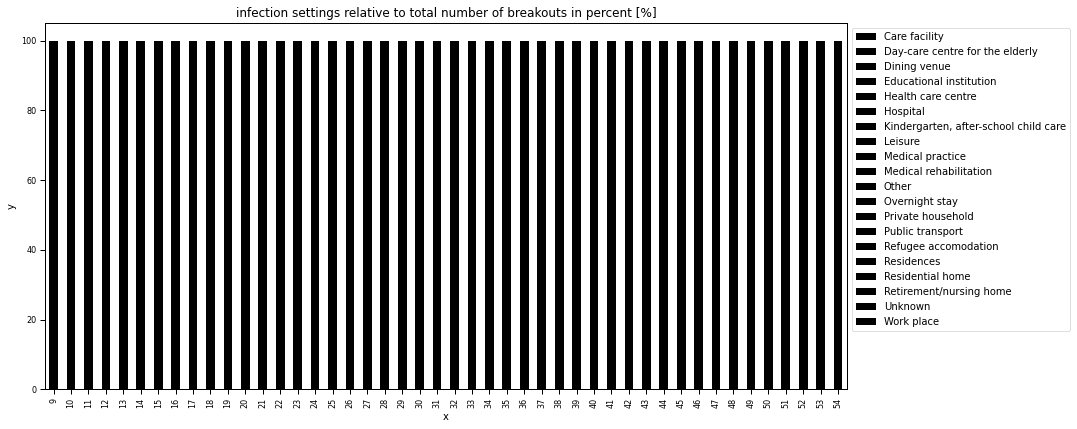

In [41]:
# of all documented breakouts, what percentage of cases occurred in which infection setting?
fig, ax = pfunc.plot_bar(breakouts_time_per_setting_rel*100,
                         title='infection settings relative to total number of breakouts in percent [%]',
                         filename='shares_breakouts',
                         stacked=True)

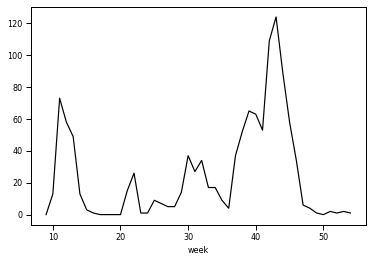

In [42]:
breakouts_time_per_setting['Dining venue'].plot()

Private households continuosly make up for a large share of the infections, and cases there often go along with peaks in other breakout settings.It seems obvious here that infections are often carried home.

Over time, there were multiple shifts: both waves come with a massive surge of cases in retirement/nursing homes (along with other care and medical facilities such as general hospitals), both in total and relative to other sources and accounting for up to 40% of cases during the second wave 
* this coincides with the high case incidences among those aged 90+
* it is unclear whether the cases among caretakers are allocated to "work place" or the medical facility they work in.

During summer, when overall case numbers were low, the share of infection sources which can be attributed to private households and social life grows. There is a distinct peak of workplace breakouts in June, which can be directly explained by a single breakout in a meat factory with over 2000 infections among employees and relatives.

The number of "unknown" infection sources seems pretty low and stable, given the fact that there were two pandemic waves with rapidly increasing numbers of Coronavirus infections. _But_ as a) infection sources are only documented for breakouts, and b) as only 2 or more related cases are documented as a breakout, we have to assume that the infection source of all remaining cases is unknown:

`single_unknown_cases = total_cases - sum(cases_from_breakouts)`

In [43]:
# calculate weekly cases with unknown infection setting as: single_unknown_cases = total_cases - sum(cases_from_breakouts)
unknown_cases = pd.concat([weekly_cases, breakouts_time_per_setting.sum(axis=1).rename('weekly_sum_breakouts')], axis=1).fillna(0).loc[:53, :]
unknown_cases['weekly_single_unknown_cases'] = unknown_cases['AnzahlFall'] - unknown_cases['weekly_sum_breakouts']
unknown_cases['weekly_sum_breakouts_perc'] = unknown_cases['weekly_sum_breakouts']/unknown_cases['AnzahlFall']

mean_reported = unknown_cases['weekly_sum_breakouts_perc'].loc[9:].mean()
print(f'mean percentage of cases that are attributed to a breakout (starting week 9): {round(mean_reported*100, 2)}%')

mean percentage of cases that are attributed to a breakout (starting week 9): 29.92%


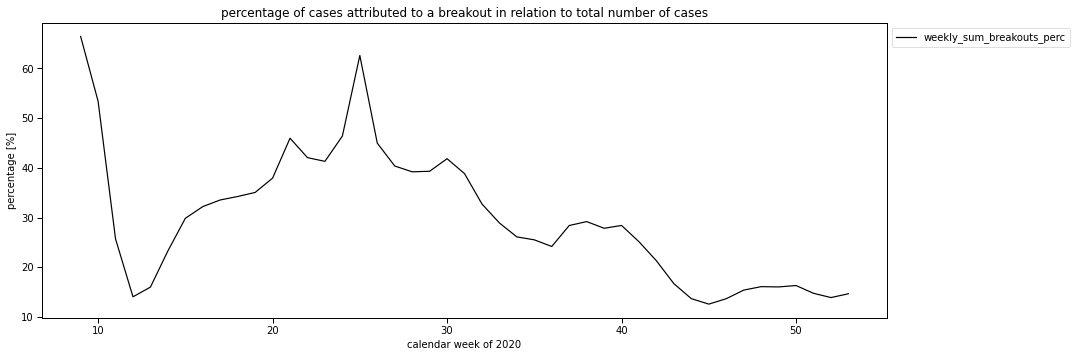

In [44]:
# percentage of cases attributed to a breakout in relation to total number of cases
fig, ax = pfunc.plot_line(unknown_cases['weekly_sum_breakouts_perc'].loc[9:]*100,
                          title=f'percentage of cases attributed to a breakout in relation to total number of cases',
                          ylabel='percentage [%]', 
                          xlabel='calendar week of 2020', 
                          linecolor=default,
                          filename='traced_cases_perc')

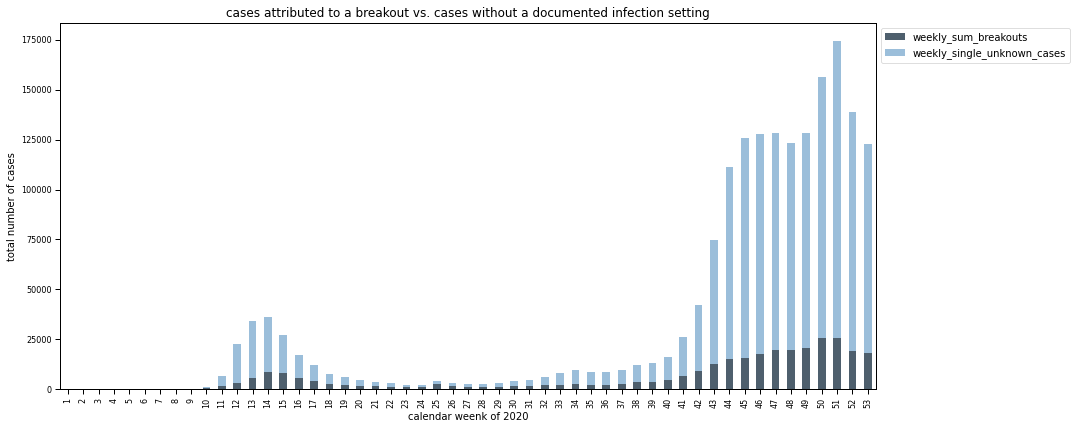

In [45]:
# total number of cases as: cases attributed to a breakout vs. cases without a documented infection setting
fig, ax = pfunc.plot_bar(unknown_cases[['weekly_sum_breakouts', 'weekly_single_unknown_cases']],
                          title=f'cases attributed to a breakout vs. cases without a documented infection setting',
                          color=[blue_dark, blue_light], 
                          xlabel='calendar weenk of 2020',
                        ylabel='total number of cases', 
                          filename='unknown_vs_known_cases', stacked=True)

In [46]:
print(f'average cases attributed to a breakout: {unknown_cases.weekly_sum_breakouts_perc.loc[9:].mean()*100}\
\n...during summer (week 20-40): {unknown_cases.weekly_sum_breakouts_perc.loc[20:40].mean()*100}\
\n...during second wave (week 41-53): {unknown_cases.weekly_sum_breakouts_perc.loc[41:53].mean()*100}')

average cases attributed to a breakout: 29.923843214858554
...during summer (week 20-40): 36.77357769090084
...during second wave (week 41-53): 16.189474133794057


On average, 30% of cases are attributed to a breakout setting. When infection rates rose the fastest, i.e. at the beginning of both pandemic waves, this percentage dropped significantly, to 14.1% during the first wave and 12.6% during the second. Only in February and during summer, when infection rates were low, a larger share of cases was traced back to a specific infection setting. The beginning of the first wave and the well-documented meat factory incident make up for significant peaks here, again.

In [47]:
# add single unknown cases to breakouts
breakouts_time_per_setting2 = breakouts_time_per_setting.copy(deep=True)
breakouts_time_per_setting2['Unknown single'] = unknown_cases['weekly_single_unknown_cases'].loc[9:]
breakouts_time_per_setting2['Unknown total'] = breakouts_time_per_setting2['Unknown single'] + breakouts_time_per_setting2['Unknown']

# calculate new numbers and percentages of breakouts
breakouts_time_per_setting_rel2 = (breakouts_time_per_setting2.drop(['Unknown single', 'Unknown'], axis=1)
                                   .div(breakouts_time_per_setting2.drop(['Unknown single', 'Unknown'], axis=1).sum(axis=1), axis=0)).fillna(0)

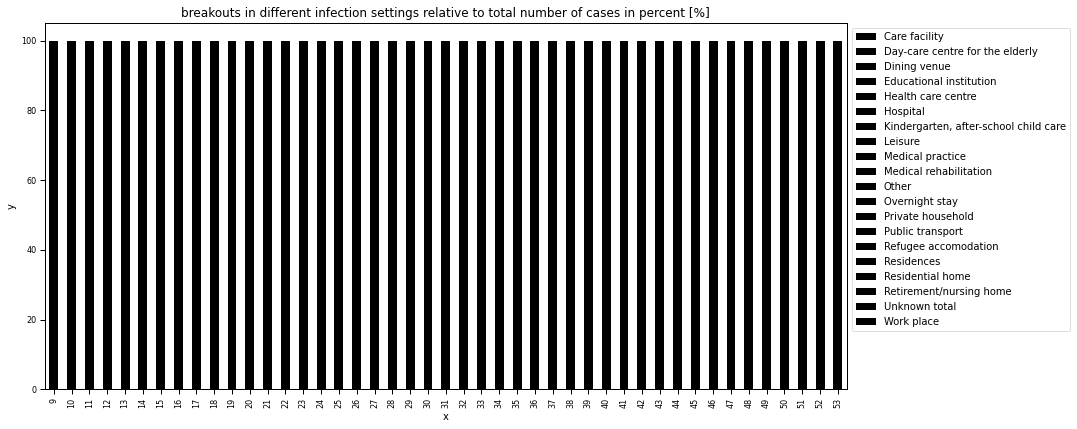

In [48]:
fig, ax = pfunc.plot_bar((breakouts_time_per_setting_rel2.reindex(sorted(breakouts_time_per_setting_rel2.columns), axis=1).loc[:53,:])*100,
                          title=f'breakouts in different infection settings relative to total number of cases in percent [%]',
                          filename='shares_breakouts_total', stacked=True)

Adding individual cases to the “unknown” category of infection settings yields more realistic picture of the status of case tracing. The vast majority of cases now comes from unknown sources — during the second wave, around 85%. This indicates that especially during times of high infection rates, authorities were overwhelmed with case tracing and would hence be at a higher risk to miss infection chains, which would drive up the number of undetected cases.

In [49]:
# correlations between relative incidence in age groups and reported breakouts
age_norm_trans = age_norm.rename(columns={'2021_1': '54'}).T
age_norm_trans.index = age_norm_trans.index.astype('int').rename('week')
age_vs_breakouts = pd.concat([breakouts_time_per_setting2, age_norm_trans], axis=1)
age_vs_breakouts_summer = pd.concat([breakouts_time_per_setting2, age_norm_trans], axis=1).loc[18:44, :]

# correlation age vs breakouts: take upper right side of correlation matrix
age_vs_breakouts_corr = age_vs_breakouts.corr().loc[:'Work place', '90+':]

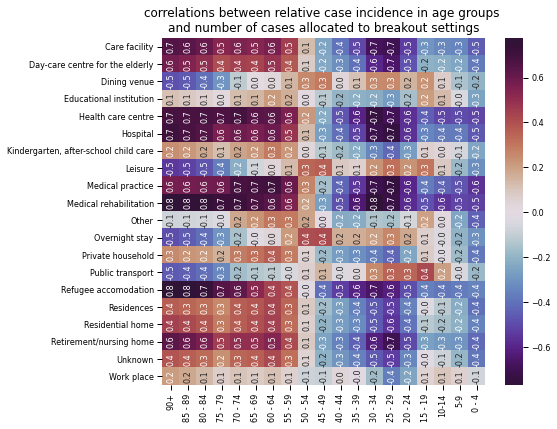

In [50]:
# correlations between relative case incidence in age groups and number of cases allocated to breakout settings
fig, ax = pfunc.plot_heatmap(age_vs_breakouts_corr,
                             title=f'correlations between relative case incidence in age groups \nand number of cases allocated to breakout settings',
                             filename='corr_age_breakouts',
                             annot=True, fmt='.1f', figsize=(8,6), center=0)

The correlations here back the assumption that elderly people being overproportionally affected by Coronavirus infections (in comparison the general population) highly correlate with breakouts in nursing homes and medical facilities. Younger people on the other hand seem to rather catch infections in settings related to social live.

#### clinical data

In [51]:
# clinical data: cases, symptoms, hospitalisation
clinical[['no_symptoms_perc', 'hospital_perc', 'deaths_perc']] = clinical[['no_symptoms_perc', 'hospital_perc', 'deaths_perc']]*100

# rates of clinical status reporting for all known cases
clinical['symptom_status_known'] = clinical['symptoms_reported']/clinical['cases_tot']
clinical['hospital_status_known'] = clinical['hospital_reported']/clinical['cases_tot']

# number of known asymptotic cases
clinical['no_symptoms_num'] = clinical['symptoms_reported']*clinical['no_symptoms_perc']/100

clinical['death_vs_tot'] = clinical['deaths_num']/clinical['cases_tot']
clinical['hospital_vs_tot'] = clinical['hospital_num']/clinical['cases_tot']
clinical['asymptomatic_vs_tot'] = clinical['no_symptoms_num']/clinical['cases_tot']

In [52]:
# cumulative percentages of hospitalized cases and deaths per total number of cases
hospitalized_cum = clinical['hospital_num'].sum()/clinical['cases_tot'].sum()
deaths_cum = clinical['deaths_num'].sum()/clinical['cases_tot'].sum()
clinical_corrs = clinical[['cases_tot', 'hospital_num', 'deaths_num']].corr()

print(f'cumulative hospitalizations per total number of infections: {round(hospitalized_cum*100, 2)}%\
        \ncumulative deaths per total number of infections: {round(deaths_cum*100, 2)}%')

cumulative hospitalizations per total number of infections: 6.65%        
cumulative deaths per total number of infections: 2.16%


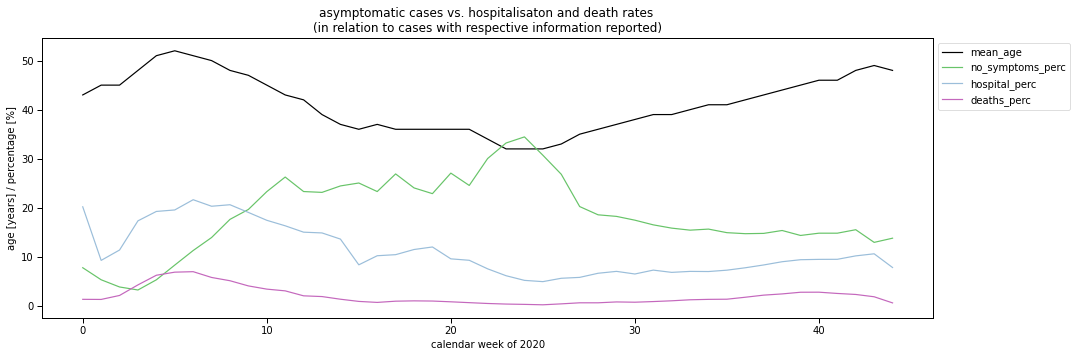

In [53]:
# percentages of hospitalized cases and deaths per cases for whiche the respective information was provided
fig, ax = pfunc.plot_line(clinical[['mean_age', 'no_symptoms_perc', 'hospital_perc', 'deaths_perc']],
                          title=f'asymptomatic cases vs. hospitalisaton and death rates \n(in relation to cases with respective information reported)',
                          ylabel='age [years] / percentage [%]',
                          xlabel='calendar week of 2020', 
                          linecolor=['black', color1[0], blue_light, color2[1]],
                          filename='clinical_rates_reported')

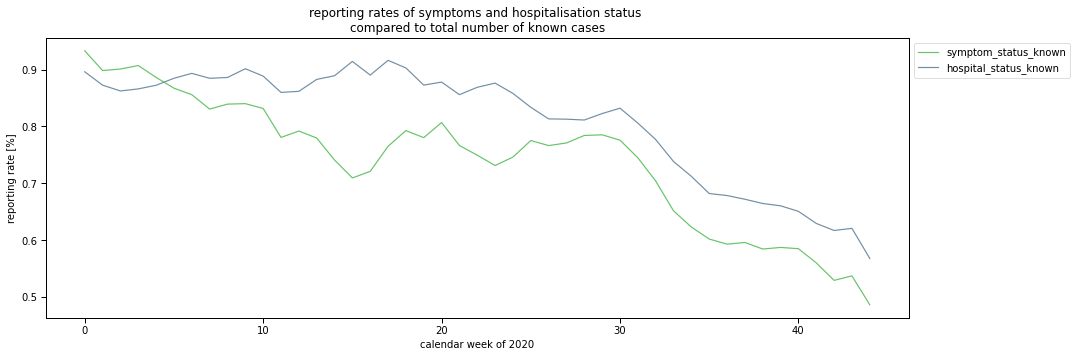

In [54]:
fig, ax = pfunc.plot_line(clinical[['symptom_status_known', 'hospital_status_known']],
                          title=f'reporting rates of symptoms and hospitalisation status \ncompared to total number of known cases',
                          ylabel='reporting rate [%]',
                          xlabel='calendar week of 2020', 
                          linecolor=[color1[0], blue_medium],
                          filename='reporting_rates')

#### estimate number of undetected cases (dark figures) across age groups
implementing a statistical approach based on a study on the influence of social contacts on the spread of infectious diseases. The approach was introduced by Dr. Sascha Feth from the Fraunhofer Institute for Industrial Mathematics ITWM in his [blog](https://www.itwm.fraunhofer.de/de/abteilungen/mf/aktuelles/blog-streuspanne/corona-dunkelziffer.html) and applied to cases in Italy in April 2020.

In [55]:
# normalize relative number of social contacts for the population 70+ to be the benchmark
social_factors = social_factors/social_factors['social_contacts'].loc['90+']

In [56]:
social_factors

,social_contacts,social_contacts_95_low,social_contacts_95_high
Altersgruppe,,,
90+,1.000000,0.901235,1.086420
85 - 89,1.000000,0.901235,1.086420
80 - 84,1.000000,0.901235,1.086420
75 - 79,1.000000,0.901235,1.086420
70 - 74,1.000000,0.901235,1.086420
65 - 69,1.308642,1.185185,1.432099
60 - 64,1.308642,1.185185,1.432099
55 - 59,1.617284,1.481481,1.753086
50 - 54,1.617284,1.481481,1.753086


In [57]:
# assume benchmark incidence for all age groups
age_incidence_max = age_incidence.copy(deep=True)

for col in age_incidence.columns:
    # replace all incidences with the highest one at the time
#     age_incidence_max[col] = age_incidence[col].max()
    # if max incidence is among those 70+ years of age, take that incidence as benchmark
    if (age_incidence[col].max() == age_incidence[col].loc['90+'])|\
    (age_incidence[col].max() == age_incidence[col].loc['85 - 89'])|\
    (age_incidence[col].max() == age_incidence[col].loc['80 - 84'])|\
    (age_incidence[col].max() == age_incidence[col].loc['75 - 79'])|\
    (age_incidence[col].max() == age_incidence[col].loc['70 - 74']):
        age_incidence_max[col] = age_incidence[col].max()
    
age_incidence_max = age_incidence_max.iloc[1:,:]
age_incidence_max

,10,11,12,13,14,15,16,17,18,19,...,45,46,47,48,49,50,51,52,53,2021_1
Altersgruppe,,,,,,,,,,,,,,,,,,,,,
90+,0.12,1.46,12.03,51.39,142.4,151.27,103.03,70.71,34.51,25.27,...,208.98,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
85 - 89,0.38,2.43,13.94,47.19,142.4,151.27,103.03,70.71,34.51,25.27,...,146.50,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
80 - 84,0.36,2.52,14.21,39.01,142.4,151.27,103.03,70.71,34.51,25.27,...,104.18,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
75 - 79,0.62,2.89,14.73,36.30,142.4,151.27,103.03,70.71,34.51,25.27,...,78.55,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
70 - 74,0.30,3.92,16.93,36.09,142.4,151.27,103.03,70.71,34.51,25.27,...,86.33,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
65 - 69,0.51,4.88,18.32,33.96,142.4,151.27,103.03,70.71,34.51,25.27,...,87.22,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
60 - 64,1.10,7.63,28.29,44.73,142.4,151.27,103.03,70.71,34.51,25.27,...,121.20,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
55 - 59,1.11,11.16,38.58,53.37,142.4,151.27,103.03,70.71,34.51,25.27,...,150.71,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28
50 - 54,1.98,14.60,46.12,59.63,142.4,151.27,103.03,70.71,34.51,25.27,...,163.09,281.15,372.4,427.31,502.77,656.95,722.19,635.69,600.09,641.28


In [58]:
# get estimated incidences: multiply by relative number of social contacts (including 95% intervals)
age_incidence_factorized = age_incidence_max.mul(social_factors['social_contacts'], axis=0)
age_incidence_factorized_95_low = age_incidence_max.mul(social_factors['social_contacts_95_low'], axis=0)
age_incidence_factorized_95_high = age_incidence_max.mul(social_factors['social_contacts_95_high'], axis=0)

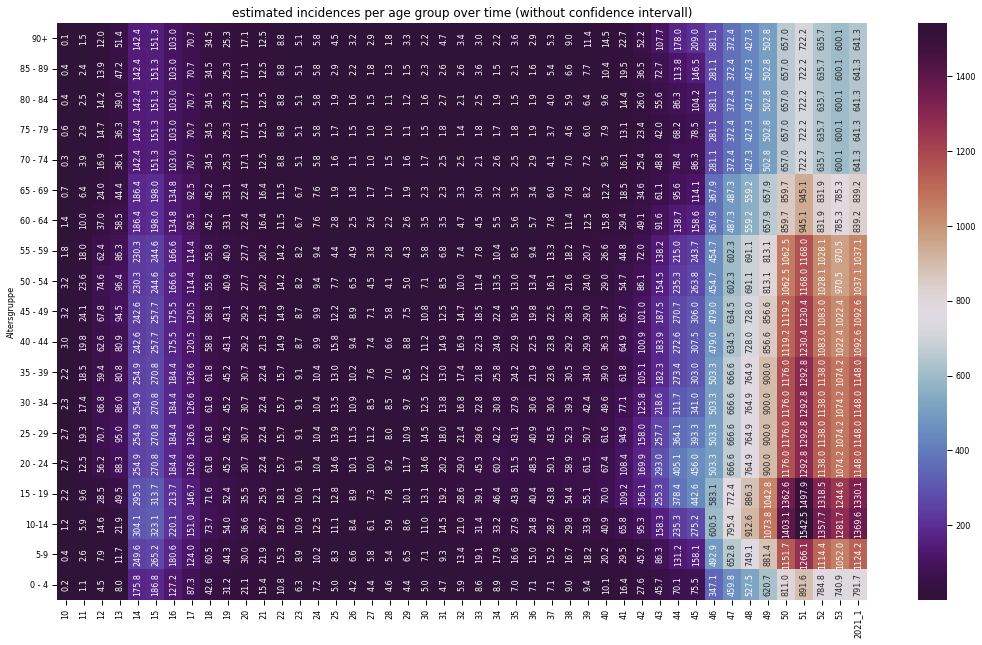

In [59]:
# heatmap: estimated incidences per age group over time (without confidence intervall)
fig, ax = pfunc.plot_heatmap(age_incidence_factorized,
                             title='estimated incidences per age group over time (without confidence intervall)',
                             filename='estimated_incidences_per_age',
                             figsize=(15, 9), annot=True, fmt='.1f')

In [60]:
# get estimated total numbers per age group
age_cases_factorized = ((age_incidence_factorized.mul(population_age, axis=0))/100).loc[:, :'53']
age_cases_factorized_95_low = ((age_incidence_factorized_95_low.mul(population_age, axis=0))/100).loc[:, :'53']
age_cases_factorized_95_high = ((age_incidence_factorized_95_high.mul(population_age, axis=0))/100).loc[:, :'53']

In [68]:
# get cumulated estimation of total numbers over time
dark_figs = pd.DataFrame()
dark_figs['cases_est'] = age_cases_factorized.sum()
dark_figs['cases_95_low'] = age_cases_factorized_95_low.sum()
dark_figs['cases_95_high'] = age_cases_factorized_95_high.sum()
dark_figs.index = dark_figs.index.astype('int')

dark_figs = pd.concat([dark_figs, weekly_cases.rename('confirmed_cases')], axis=1)

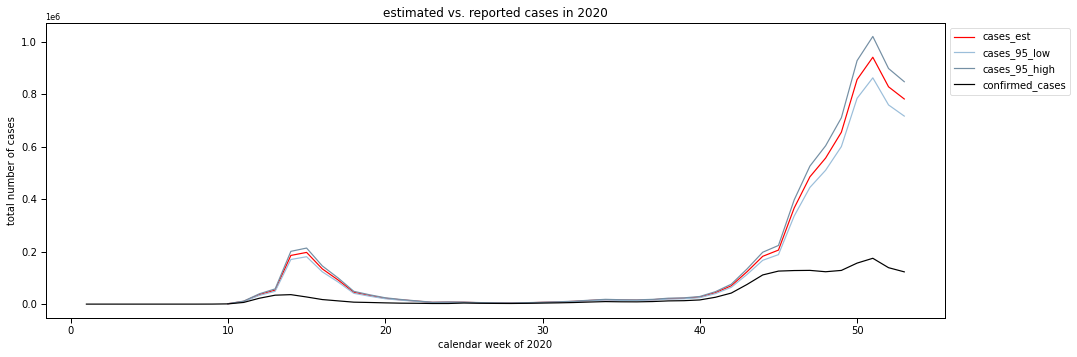

In [69]:
fig, ax = pfunc.plot_line(dark_figs,
                          title=f'estimated vs. reported cases in 2020',
                          ylabel='total number of cases',
                          xlabel='calendar week of 2020', 
                          linecolor=['red', blue_light, blue_medium, 'black'],
                          filename='estimated_dark_figures')

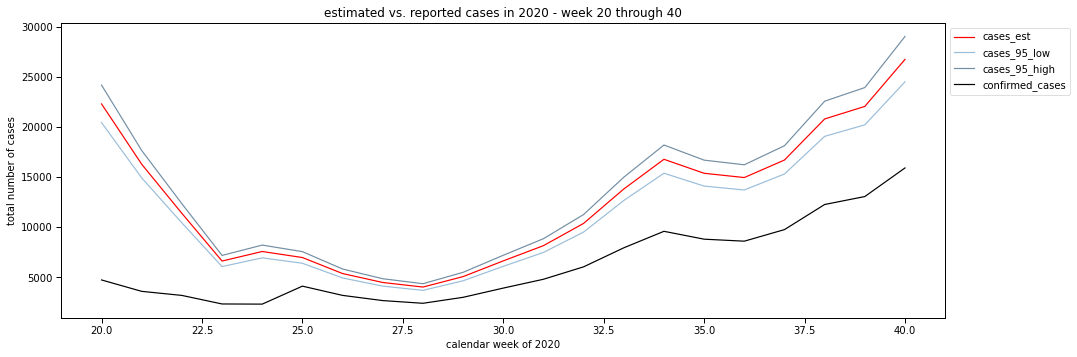

In [70]:
fig, ax = pfunc.plot_line(dark_figs.loc[20:40, :],
                          title=f'estimated vs. reported cases in 2020 - week 20 through 40',
                          ylabel='total number of cases',
                          xlabel='calendar week of 2020', 
                          linecolor=['red', blue_light, blue_medium, 'black'],
                          filename='estimated_dark_figures_summer')

Plotting estimated cases over confirmed infections visualizes the surge in case numbers even better: up to 5 times more Coronavirus infections than reported are estimated by our model during both pandemic waves. Zooming in on case numbers during summer reveals that even with low official case numbers and no benchmarking, estimated case numbers are at least twice as high as indicated by records.

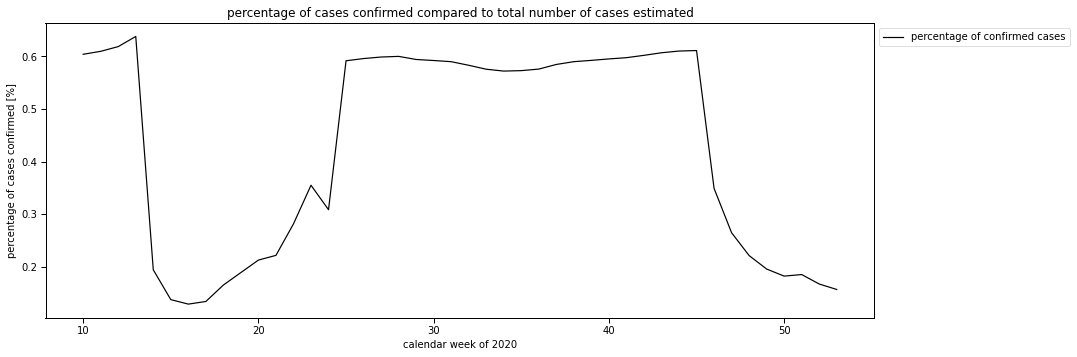

In [71]:
fig, ax = pfunc.plot_line((dark_figs['confirmed_cases']/dark_figs['cases_est']).rename('percentage of confirmed cases'),
                          title=f'percentage of cases confirmed compared to total number of cases estimated',
                          ylabel='percentage of cases confirmed [%]',
                          xlabel='calendar week of 2020', 
                          linecolor=['black'],
                          filename='percentage_confirmed_cases')

Within the percentage of confirmed cases vs. the total number of estimated cases, we can see the distinct shifts between both pandemic waves - where the elderly age group was the benchmark - and those times with lesser overall infections, where infections were higher in different groups.

A possible change to the approach taken could be to not assume any specific group as benchmark, but to always take the one with the highest incidences. It is questionable though if this would lead to a more accurate estimation though: the specific breakouts discussed earlier (i.e. the meat factory breakout in June) would have a larger influence on undetected cases across all age groups, regardless of the fact that they might indeed have occurred in a closed and well-documented setting.

In [72]:
# account for further uncertainty due to 0-40% asymptomatic cases
dark_figs['cases_est_uncertainty'] = dark_figs['cases_est']*1.4
dark_figs['cases_95_low_uncertainty'] = dark_figs['cases_95_low']*1.4
dark_figs['cases_95_high_uncertainty'] = dark_figs['cases_95_high']*1.4

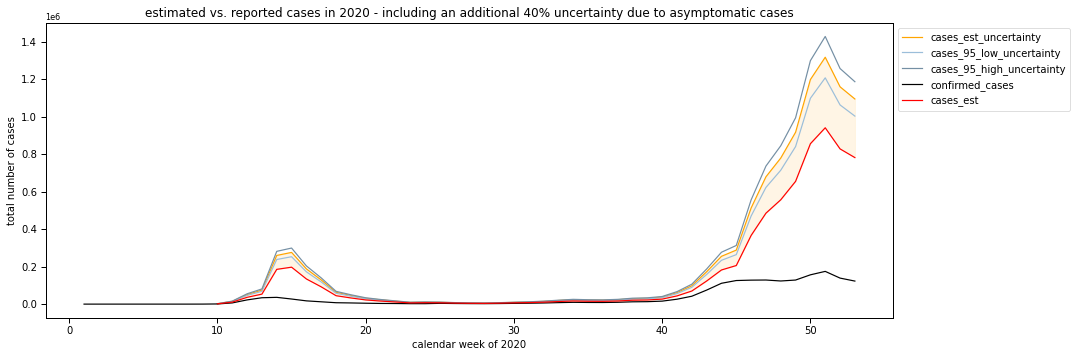

In [73]:
fig, ax = pfunc.plot_line_fill(dark_figs[['cases_est_uncertainty', 'cases_95_low_uncertainty', 'cases_95_high_uncertainty', 'confirmed_cases', 'cases_est']],
                               dark_figs['cases_est'], 
                               dark_figs['cases_est_uncertainty'], 
                               title=f'estimated vs. reported cases in 2020 - including an additional 40% uncertainty due to asymptomatic cases',
                          ylabel='total number of cases',
                          xlabel='calendar week of 2020', 
                          linecolor=['orange', blue_light, blue_medium, 'black', 'red'], fillcolor='orange',
                          filename='estimated_dark_figures_uncertainty')

Check out this [dashboard](https://covid19.dunkelzifferradar.de/) for another approach for estimating undetected Coronavirus infections based on case mortality. The model uses differential equations, wherein the mortality parameter can be configured by the user.

At the peak of the second wave in CW 51, this dashboard yields a maximum number of undetected infections of over 1.6 million cases, which is double the value derived from the calculation above and 8 times the number of reported cases.